In [1]:
import os
import csv
import platform
import pandas as pd
import networkx as nx
from graph_partitioning import GraphPartitioning, utils

cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "MODULARITY", "LONELINESS", "NETWORK PERMANENCE", "NORM. MUTUAL INFO"]
pwd = %pwd

run_metrics = True

# OUTSTANDING ISSUES
# ISSUE [x]: sliding window bug
# ISSUE [x]: integrate NMI score
# ISSUE []: disable OSLOM: or get RELATIVE PATH BETWEEN EXE AND DATA FILE
# ISSUE []: merge with master
# ISSUE []: GAM Model - make sure it uses assignments and not prediction model
# ISSUE []: debug internals of PaToH for data conversion
# ISSUE []: debug internals of SCOTCH & upgrade SCOTCH
# ISSUE []: debug virtual nodes performance
# ISSUE []: hyperedge expansion experiments in batch_mode
# ISSUE []: virtual nodes?

config = {

    "DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "network_1.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "PATOH",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    
    "PARTITIONER_ALGORITHM": "PATOH",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd,
                                           "data",
                                           "predition_model_tests",
                                           "dataset_1_shift_rotate",
                                           "simulated_arrival_list",
                                           "percentage_of_prediction_correct_90",
                                           "arrival_90_1.txt"
                                          ),
    
    # File containing the prediction of a node arriving. This is different to the
    # simulated arrivals, the values in this file are known before the disaster.
    "PREDICTION_LIST_FILE": os.path.join(pwd,
                                         "data",
                                         "predition_model_tests",
                                         "dataset_1_shift_rotate",
                                         "prediction_list",
                                         "prediction_1_norm.txt"
                                        ),

    # File containing the geographic location of each node, in "x,y" format.
    "POPULATION_LOCATION_FILE": os.path.join(pwd,
                                             "data",
                                             "predition_model_tests",
                                             "coordinates",
                                             "coordinates_1.txt"
                                            ),

    # Number of shelters
    "num_partitions": 6,

    # The number of iterations when making prediction model
    "num_iterations": 1,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.10,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    # When set to 1, one-shot is used with alpha value from above
    "restream_batches": 10,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,

    # Loneliness score parameter. Used when scoring a partition by how many
    # lonely nodes exist.
    "loneliness_score_param": 1.2,

    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": False,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": True,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": False,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    
    "SCOTCH_LIB_PATH": os.path.join(pwd, "libs/scotch/macOS/libscotch.dylib")
    if 'Darwin' in platform.system()
    else "/usr/local/lib/libscotch.so",
    
    # Path to the PaToH shared library
    "PATOH_LIB_PATH": os.path.join(pwd, "libs/patoh/lib/macOS/libpatoh.dylib")
    if 'Darwin' in platform.system()
    else os.path.join(pwd, "libs/patoh/lib/linux/libpatoh.so"),
    
    "PATOH_ITERATIONS": 5,
        
    # Expansion modes: 'avg_node_weight', 'total_node_weight', 'smallest_node_weight'
    # 'largest_node_weight'
    # add '_squared' or '_sqrt' at the end of any of the above for ^2 or sqrt(weight)
    # i.e. 'avg_node_weight_squared
    "PATOH_HYPEREDGE_EXPANSION_MODE": 'no_expansion',

    # Alters how much information to print. Keep it at 1 for this notebook.
    # 0 - will print nothing, useful for batch operations.
    # 1 - prints basic information on assignments and operations.
    # 2 - prints more information as it batches arrivals.
    "verbose": 1

}

gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
gp.load_network()

Graph loaded...
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 2938
Average degree:   5.8760
Graph is undirected


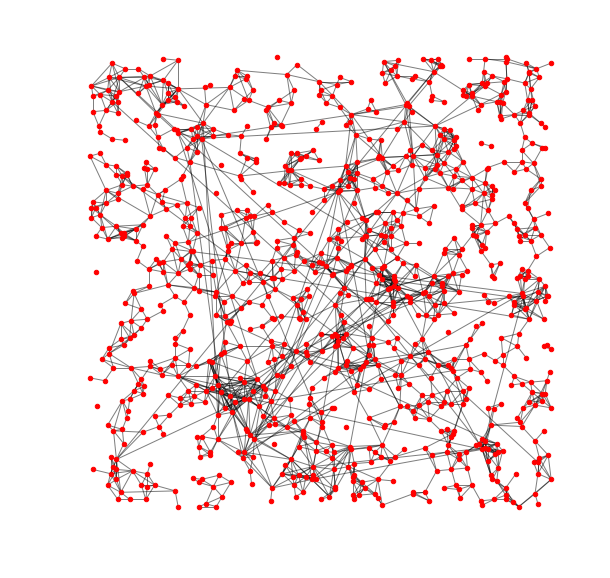

In [3]:
pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')

nx.draw_networkx_nodes(gp.G, pos, node_size=20, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

In [4]:
gp.init_partitioner()

PaToH partitioner loaded for generating PREDICTION MODEL.
PaToH partitioner loaded for making shelter assignments.


## PaToH Hyperedge Expansion Modes

In [5]:
test_all_expansion_modes = False
if test_all_expansion_modes:
    # Expansion modes: 'avg_node_weight', 'total_node_weight', 'smallest_node_weight'
    # 'largest_node_weight'
    # add '_squared' or '_sqrt' at the end of any of the above for ^2 or sqrt(weight)
    # i.e. 'avg_node_weight_squared
    
    expansion_modes = ['no_expansion', 
                       'avg_edge_weight', 
                       'total_edge_weight',
                       'smallest_edge_weight',
                       'largest_edge_weight',
                       'avg_edge_weight_squared', 
                       'total_edge_weight_squared',
                       'smallest_edge_weight_squared',
                       'largest_edge_weight_squared',
                       'avg_edge_weight_sqrt', 
                       'total_edge_weight_sqrt',
                       'smallest_edge_weight_sqrt',
                       'largest_edge_weight_sqrt']
    
    was_quiet = gp._quiet
    gp._quiet = True
    for expansionMode in expansion_modes:
        print('Expansion Mode:', expansionMode)
        # reset data
        gp.reset()
        
        # change the expansion mode
        gp.prediction_model_algorithm.hyperedgeExpansionMode = expansionMode
        gp.prediction_model_algorithm.partitioningIterations = 50
        # run the partitioner
        m = gp.prediction_model()
        
        # data
        rows = list(range(1, len(m)+1))
        df = pd.DataFrame(m, index=rows, columns=cols)
        print(df)
        print('\n\n')
    gp._quiet = was_quiet
    gp.reset()
    gp.prediction_model_algorithm.hyperedgeExpansionMode = gp.PATOH_HYPEREDGE_EXPANSION_MODE
    gp.prediction_model_algorithm.partitioningIterations = gp.PATOH_ITERATIONS        

# Prediction Model

In [6]:
m = gp.prediction_model()

Ran PaToH for 5 iterations with min_cuts = 168 and max_cuts = 211  - picked min_cuts assignements.
PREDICTION MODEL
----------------


Assignments:
[ 0  4  3  2  5  1  2  2  1  1  4  2  5  1  0  0  5  2  1  2  1  0  0  2  3  3  2  0  5  2  3  5  4  5  0  4  5  0  5  5  1  3  1  2  5  5  4  2  2  0  2  0  4  5  0  3  3  1  5  3  0  1  1  3  2  3  2  4  2  5  1  4  5  0  2  2  5  4  3  0  4  1  0  5  4  3  1  1  3  2  0  4  2  3  0  0  0  5  5  4  2  0  4  0  0  3  5  1  4  4  2  3  3  1  0  5  0  3  2  0  4  5  1  5  3  0  3  0  5  5  2  3  2  3  1  5  2  0  2  2  1  2  1  3  4  5  0  3  3  4  0  2  1  3  0  4  2  5  2  4  1  5  3  3  5  2  4  4  4  0  1  4  2  1  2  2  3  2  3  0  1  2  4  5  1  0  0  4  2  2  0  5  2  3  0  2  0  3  1  3  2  3  1  3  5  0  2  2  5  5  3  3  1  5  5  4  1  2  2  0  3  1  2  1  4  5  1  1  3  0  0  2  3  0  3  3  5  2  4  5  0  2  1  1  2  5  2  0  4  3  0  2  1  0  0  1  5  0  0  5  0  5  1  0  0  4  0  4  5  2  4  5  1  5  5  3  5  1  3  4  5  5  1  5

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1  0.008   0.057182        168                223    0.770894    0.855961   

  NETWORK PERMANENCE  NORM. MUTUAL INFO  
1           0.379307                1.0  


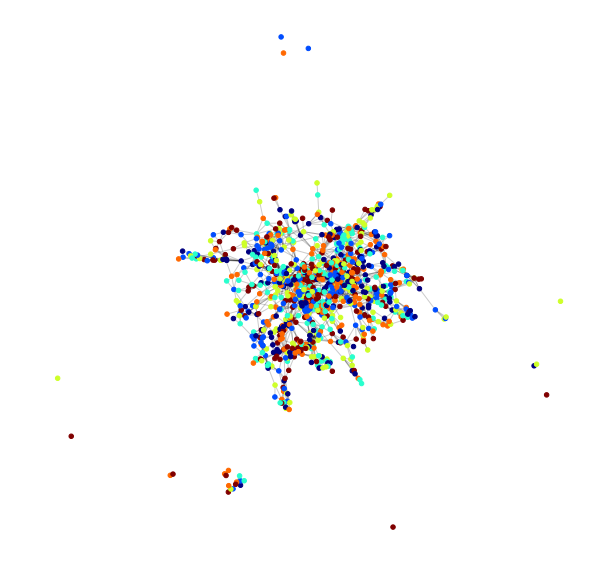

In [7]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

pos = nx.spring_layout(gp.G)
plt.figure(figsize=(10, 10))
plt.axis('off')
colours = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green'}

colour = []
#for n in gp.G.nodes_iter():
#    colour += [colours[gp.assignments[n]]]

nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=gp.assignments, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.2)
plt.show(gp.G)

# Assign Cut Off

In [8]:
m = gp.assign_cut_off()

Assign first 100 arrivals using prediction model, then discard


Assignments:
[-1 -1 -1 -1  5  1 -1 -1 -1 -1 -1 -1  5  1 -1 -1 -1  2  1 -1 -1 -1 -1 -1  3  3 -1 -1 -1  2 -1  5 -1  5 -1 -1 -1 -1  5 -1  1  3  1 -1 -1 -1 -1  2 -1 -1  2 -1 -1  5 -1  3  3 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1  2  5  4 -1 -1 -1 -1 -1  5 -1  3  1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1  5  5 -1 -1 -1 -1 -1 -1 -1  5 -1 -1  4 -1 -1  3 -1 -1  5 -1  3 -1 -1 -1  5  1  5 -1 -1 -1 -1  5 -1 -1  3 -1  3 -1  5 -1 -1 -1 -1 -1 -1 -1  3  4 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1  2  5 -1 -1 -1 -1  3 -1  5 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  3 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1  3 -1 -1 -1  3 -1 -1 -1  3 -1 -1  5 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  1 -1  1 -1  5 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1  1  2  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1  5  1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1  5  5 -1  5  1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  3  1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1  5 

In [9]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1  0.152   0.156229        459                362    0.541998    0.498084   

  NETWORK PERMANENCE  NORM. MUTUAL INFO  
1           0.379307            0.20293  


# Run Simulation

In [10]:
m = gp.batch_arrival()

Assigning in batches of 10
--------------------------------

Ran PaToH for 5 iterations with min_cuts = 13 and max_cuts = 20  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 18 and max_cuts = 26  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 29 and max_cuts = 37  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 34 and max_cuts = 41  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 37 and max_cuts = 39  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 41 and max_cuts = 49  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 46 and max_cuts = 48  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 50 and max_cuts = 62  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 70 and max_cuts = 73  - picked min_cuts assignements.
Ran PaToH for 5 iterations with min_cuts = 88 and max_cuts = 92  -

    WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1   0.160   0.126214       13.0               19.0    0.539715    0.496732   
2   0.162   0.153846       18.0               28.0    0.491546    0.489775   
3   0.170   0.201389       29.0               45.0    0.484207    0.497554   
4   0.178   0.204819       34.0               52.0    0.576587    0.518869   
5   0.186   0.207865       37.0               57.0    0.583776    0.518774   
6   0.194   0.201970       41.0               62.0    0.634033    0.552130   
7   0.184   0.210046       46.0               69.0    0.654844    0.569607   
8   0.186   0.202429       50.0               71.0    0.683303    0.597575   
9   0.188   0.250000       70.0               93.0    0.685446    0.598510   
10  0.178   0.275862       88.0              117.0    0.678718    0.617719   
11  0.180   0.291066      101.0              131.0    0.690407    0.632710   
12  0.176   0.297082      112.0              142.0    0.711250  

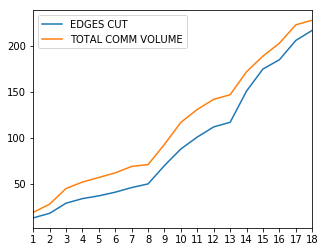

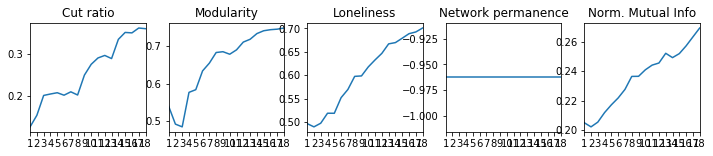

In [11]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols).astype(float)
print(df)

if len(df) > 1:
    df.plot(y=['EDGES CUT', 'TOTAL COMM VOLUME'], xticks=rows, figsize=(5,4))

    fig, axs = plt.subplots(1,5)
    df.plot(y=['CUT RATIO'], title='Cut ratio', xticks=rows, figsize=(12,2), legend=False, ax=axs[0])
    df.plot(y=['MODULARITY'], title='Modularity', xticks=rows, figsize=(12,2), legend=False, ax=axs[1])
    df.plot(y=['LONELINESS'], title='Loneliness', xticks=rows, figsize=(12,2), legend=False, ax=axs[2])
    df.plot(y=['NETWORK PERMANENCE'], title='Network permanence', xticks=rows, figsize=(12,2), legend=False, ax=axs[3])
    df.plot(y=['NORM. MUTUAL INFO'], title='Norm. Mutual Info', xticks=rows, figsize=(12,2), legend=False, ax=axs[4])

else:
    print("\n\nNot enough data points to plot charts. There is only one row.")

# Network Visual

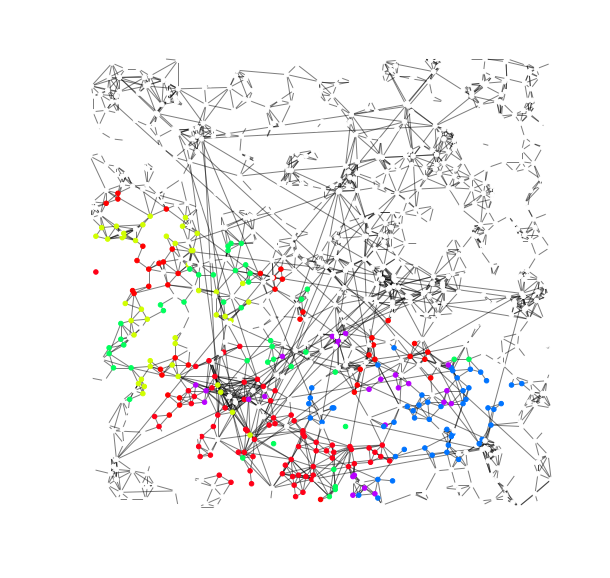

In [12]:
part = dict(zip(gp.G.nodes(), gp.assignments))
values = [part.get(node) for node in gp.G.nodes()]

pos_spring = nx.spring_layout(gp.G, k=0.5, iterations=20)

pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

# create colours
cmap = utils.get_cmap(gp.num_partitions)
colours = np.zeros((gp.G.number_of_nodes(), 4), dtype=np.float)
for i,n in enumerate(gp.G.nodes_iter()):
    if gp.assignments[n] == -1:
        col = [(1.0, 1.0, 1.0, 1.0)]
    else:
        col = [cmap(gp.assignments[n])]
    colours[i] = np.array(col, dtype=np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=colours, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

#nx.draw_networkx_nodes(gp.G, pos_spring, node_size=20, node_color=colour, cmap=plt.cm.jet, with_labels=False)
#nx.draw_networkx_edges(gp.G, pos_spring, alpha=0.5)
#plt.show(gp.G)

# Metrics

In [13]:
if run_metrics:
    gp.get_metrics()

Complete graph with 1000 nodes
['java', 'OverlappingCommunityQuality', '-weighted', '../../output/oslom/network_1-104906-all-edges-oslom.txt', '../../output/oslom/network_1-104906-all-oslom-tp.txt']

Config
-------

file: 104906
num_partitions: 6
num_iterations: 1
prediction_model_cut_off: 0.1
restream_batches: 10
use_virtual_nodes: False
virtual_edge_weight: 1.0
edges_cut: 725

Metrics
-------

waste: 0.15299999999999997
cut_ratio: 0.24676650782845472
total_communication_volume: 685
network_permanence: 0.379307
Q: 0.8438147312439847
NQ: 2.988683070937924
Qds: 0.16840625119354535
intraEdges: 61.775793650793645
interEdges: 16.3531746031746
intraDensity: 0.23977712124607498
modularity degree: 156.25369135725498
conductance: 0.20199262846745478
expansion: 0.6953155519558888
contraction: 4.415641536652437
fitness: 0.7186062652262338
QovL: 0.8830145149753706

Partition 0 with 44 nodes
-----------------------------

['java', 'OverlappingCommunityQuality', '-weighted', '../../output/oslom/net